# Reading the ROOT files

In [1]:
# %matplotlib notebook

In [2]:
import keras_tuner as kt

In [ ]:
kt.Hyperband(

In [3]:
import uproot
import numpy as np
import pandas as pd
import awkward as ak
from scipy.stats import norm
import scipy.interpolate as interpolate
from scipy.ndimage import median as med

In [26]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras import callbacks, regularizers

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Input, InputLayer
from tensorflow.keras.layers import Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelBinarizer

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
from matplotlib.colors import LogNorm
import IPython
from sklearn import metrics

In [6]:
pmtpos = np.loadtxt('pmtpositions.csv', delimiter=',')
pmtpos = np.vstack((np.array([0, 0, 0]), pmtpos))

Add in residual time and pmt info (can cut for promptness in mask if wanted. Now not doing.) 

In [7]:
ibd = ak.from_json('data/ibd.json')
fastn = ak.from_json('data/fastn.json')

## Getting data in input form

In [8]:
dimensions = [
    'n9', 'n9_prev', 'n9_next',
    'x', 'y', 'z',  'r',
    'id_plus_dr_hit', 'inner_hit_prev', 'inner_hit_next',
    'good_dir', 'good_dir_prev', 'good_dir_next',
    'good_pos','good_pos_prev', 'good_pos_next',
#     'distpmt', 
    'closestPMT', 'closestPMT_prev', 'closestPMT_next', 
    'drPrevr', 'dzPrevz', 'drNextr', 'dzNextz',
     'dt_prev_us', 'dt_next_us',
    'azimuth_ks', 'azimuth_ks_prev','azimuth_ks_next',
    'n100', 'pe', 
    'beta_one', 'beta_two', 'beta_three', 'beta_four', 'beta_five', 'beta_six',
    'beta_one_prev', 'beta_two_prev', 'beta_three_prev', 'beta_four_prev', 'beta_five_prev', 'beta_six_prev',
]
def get_dims(data, dimensions=dimensions):
    df_cut = data[dimensions]
    print('Remaining variables selected for analysis: %i'%(len(dimensions)))
    return df_cut

def prep_net_data(data_to_manipulate, 
                  prompt=True, restime=True,
                  maxlen=100):
    X = []
    y = np.array([])
    
    if prompt==True:
        keys = ['promptchan', 'promptcharge', 'prompttime']
    elif prompt==False:
        keys = ['channel', 'pmtcharge', 'hittime']
    if restime==True:
        keys.append('restime')
        
    diminput = len(keys)
    for d, dat in enumerate(data_to_manipulate):
        print('Running set %i of %i'%(d+1, len(data_to_manipulate)))
        new = np.empty(shape=(len(dat), maxlen, diminput+2))

        chn = sequence.pad_sequences(dat[keys[0]]+1, maxlen=maxlen, 
                                     padding='post', 
                                     dtype='int32')
        chrg = sequence.pad_sequences(dat[keys[1]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
        
        xyz = pmtpos[chn]+1 #since value of 0 has meaning..
        
        time = sequence.pad_sequences(dat[keys[2]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
        new[:,:,0] = chrg
        new[:,:,1] = time    
        new[:,:,2:5] = xyz+1
        
        if restime==True:
            res_times = sequence.pad_sequences(dat[keys[3]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
            new[:,:,5] = res_times
            
        if len(X)>0:
            X = np.append(X, new, axis=0)
        else: 
            X = new
        y=np.append(y, d*np.ones(len(new)))    
    return X, y

In [9]:
all_data = ak.concatenate([ibd, fastn])

In [10]:
fn = all_data['code']==2
invbeta = all_data['code']==1
id0 = all_data['subid']==0
id1p = all_data['subid']>0 # >0 changes things 

In [11]:
ibd0_mask = ak.from_iter([all(t) for t in zip(invbeta, id0)])
ibd1_mask = ak.from_iter([all(t) for t in zip(invbeta, id1p)])
fastn0_mask = ak.from_iter([all(t) for t in zip(fn, id0)])
fastn1_mask = ak.from_iter([all(t) for t in zip(fn, id1p)])

In [12]:
samples = min([ak.count_nonzero(fn), 
              ak.count_nonzero(ibd0_mask), 
              ak.count_nonzero(ibd1_mask)])
x1 = all_data[fn][:samples]
x1 = ak.concatenate((x1, all_data[ibd0_mask][:samples]))
x1 = ak.concatenate((x1, all_data[ibd1_mask][:samples]))

data_to_manipulate = [all_data[fn][:samples],
                     all_data[ibd0_mask][:samples], all_data[ibd1_mask][:samples]
                     ]

In [53]:
X1 = get_dims(x1, dimensions=dimensions)
X1 = ak.to_pandas(X1)

X2, y = prep_net_data(data_to_manipulate, prompt=False, restime=True, maxlen=200)

lb = LabelBinarizer()
y = lb.fit_transform(y)
indices = x1['timestamp']
# Split dataset into training set and test set
X_train1, X_test1, X_train2, X_test2, y_train, y_test, ind_train, ind_test= train_test_split(X1, X2, 
                                                                         y, indices, 
                                                                         test_size=0.25, random_state=43) 
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train1)
X_test1 = sc.transform(X_test1)

Remaining variables selected for analysis: 42
Running set 1 of 3
Running set 2 of 3
Running set 3 of 3


In [67]:
tested_ibd = ibd[[x in ind_test for x in ibd['timestamp']]]
tested_fastn = fastn[[x in ind_test for x in fastn['timestamp']]]

In [74]:
ibd_test_labels = y_test_2[y_test_2!=0]

In [77]:
ibd_test_labels

array([1, 2, 2, ..., 2, 2, 1])

In [73]:
tested_ibd.subid

<Array [1, 1, 1, 0, 1, 1, ... 1, 1, 1, 1, 1, 1] type='8615 * int64'>

In [69]:
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [68]:
pred_ibd = 

<Array [{gtid: 20, mcid: 33, ... 900]}] type='8615 * {"gtid": int64, "mcid": int...'>

## Non-sequential Model

In [19]:
modelload = load_model("weights/812scan_best_model_3class.h5")

In [22]:
scores = modelload.predict([X_test1, X_test2])

In [23]:
y_pred_2 = np.argmax(scores, axis=1)
y_test_2 = np.argmax(y_test, axis=1)

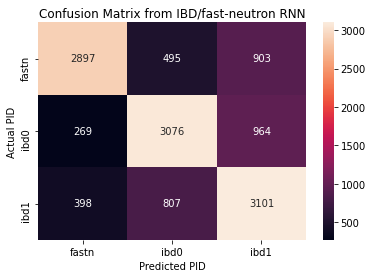

In [24]:
confmat = confusion_matrix(y_test_2, y_pred_2)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from IBD/fast-neutron RNN')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['fastn', 'ibd0', 'ibd1'])
ax.yaxis.set_ticklabels(['fastn', 'ibd0', 'ibd1'])

plt.show()

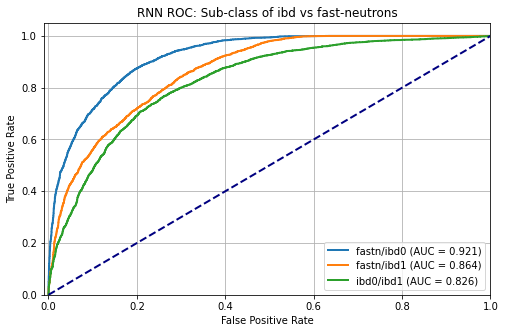

In [25]:
cat1 = [0, 0, 1]
cat2 = [1, 2, 2]
labels = ['fastn/ibd0', 'fastn/ibd1', 'ibd0/ibd1', 
         ]
plt.figure(figsize=(8,5))
for i, j, label in zip(cat1, cat2, 
                        labels,
                         ):
    mask = [any(t) for t in zip(y_test_2==i, y_test_2==j)]
    prob = scores[:, j][mask]
    
    guesses = y_test_2[mask]
    guesses = guesses - np.min(guesses)
    guesses = guesses/np.max(guesses)

    fpr, tpr, thresholds = roc_curve(guesses, prob)
        
    auc = roc_auc_score(y_test_2[mask], prob)
    plt.plot(fpr, tpr, 
         label='%s (AUC = %0.3f)'%(label, auc), 
#          color='darkorange', 
         lw=2, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RNN ROC: Sub-class of ibd vs fast-neutrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.grid()
plt.show()

## Clustering predictions 

Goal: Cluster the predictions together by nearby in time and try to come up with some ensembled prediction on whether or not it is a fast-n vs. ibd.

In [104]:
plt.plot(history['val_loss'], 
         color='r', lw=2, label='Validation Loss', 
        )
plt.plot(history['loss'], 
         color='b', lw=2, label='Training Loss', 
        )

plt.plot(history['val_acc'], 
         color='r', lw=2, linestyle='--', 
         label='Validation Accuracy', 
        )
plt.plot(history['loss'], 
         color='b', lw=2, linestyle='--', 
         label='Training Accuracy', 
        )

NameError: name 'history' is not defined

In [112]:
scores = newModel2.predict([X_test1, X_test2])

In [113]:
y_pred_2 = np.round(scores)
y_test_2 = y_test

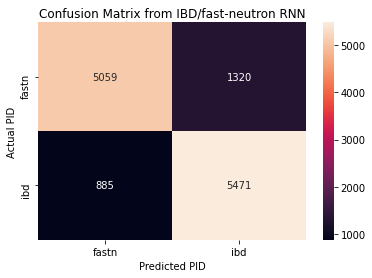

In [114]:
confmat = confusion_matrix(y_test_2, y_pred_2)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from IBD/fast-neutron RNN')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['fastn', 'ibd'])
ax.yaxis.set_ticklabels(['fastn', 'ibd'])

plt.show()

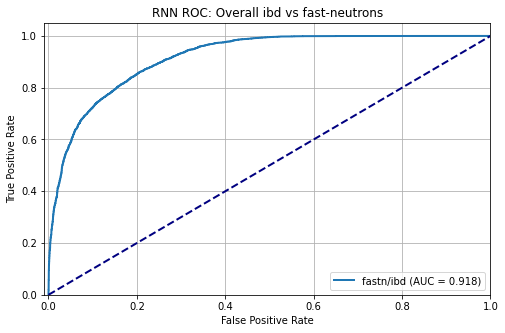

In [117]:
cat1 = [0]
cat2 = [1]
labels = ['fastn/ibd', 
         ]
plt.figure(figsize=(8,5))
for i, j, label in zip(cat1, cat2, 
                        labels,
                         ):
    mask = [any(t) for t in zip(y_test_2==i, y_test_2==j)]
    prob = scores[mask]
    
    guesses = y_test_2[mask]
    guesses = guesses - np.min(guesses)
    guesses = guesses/np.max(guesses)

    fpr, tpr, thresholds = roc_curve(guesses, prob)
        
    auc = roc_auc_score(y_test_2[mask], prob)
    plt.plot(fpr, tpr, 
         label='%s (AUC = %0.3f)'%(label, auc), 
#          color='darkorange', 
         lw=2, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RNN ROC: Overall ibd vs fast-neutrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.grid()
plt.show()

In [131]:
wrong = X_save[y_pred_2!=y_test]

In [129]:
rightpred = y_test[y_pred_2!=y_test]

In [158]:
fastnwrong = fastn[wrong[rightpred==0].index.values]
ibdwrong = ibd[wrong[rightpred==1].index.values-samples]

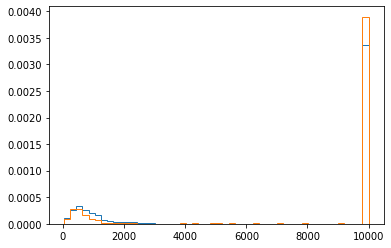

In [182]:
key = 'drPrevr'
kw = dict(histtype='step', density=True)
bins = plt.hist(fastnwrong[key], bins=50, **kw)
plt.hist(ibdwrong[key], bins=bins[1], **kw)
plt.show()